In [1]:
import modesto.main
import pandas as pd
import networkx as nx
import modesto.utils as ut
import logging
import matplotlib.pyplot as plt

import time

%matplotlib notebook

In [2]:
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')

## Time parameters
Full year optimization

In [3]:
n_steps = 365*24
time_step = 3600
horizon = n_steps*time_step
start_date = pd.Timestamp('20140101')

## Design parameters
Storage size, solar thermal panel size,...

In [4]:
storVol = 75000
solArea = 2*(18300+ 15000)
backupPow = 1.3* 3.85e6  # +10% of actual peak boiler power

## Network layout
No network, single node.

In [5]:
netGraph = nx.DiGraph()
netGraph.add_node('Node', x=0, y=0, z=0, comps={
    'backup': 'ProducerVariable',
    'storage': 'StorageVariable',
    'solar': 'SolarThermalCollector',
    'demand': 'BuildingFixed'
})

begin = time.time()

## Modesto optimizer instance

In [6]:
optmodel = modesto.main.Modesto(horizon=horizon, time_step=time_step, graph=netGraph,
                                pipe_model='SimplePipe')

03-05 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter Te
03-05 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter Tg
03-05 11:04 modesto.Node                         INFO     Initializing Node Node
03-05 11:04 modesto.component.Component          INFO     Initializing Component storage
03-05 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter Thi
03-05 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter Tlo
03-05 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter mflo_max
03-05 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter mflo_min
03-05 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter volume
03-05 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter ar
03-05 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter dIns
03-05 11:04 modesto.parameter.Parameter          INFO 

## Read demand and production profiles

In [7]:
dem = ut.read_time_data(path='../Data/HeatDemand/Initialized', 
                          name='HeatDemandFiltered.csv')

In [8]:
dem.mean()/1e6*8760

TermienWest          26122.430422
TermienEast          38698.169732
Boxbergheide         96187.448597
Winterslag          133359.435282
OudWinterslag        14098.477935
ZwartbergSouth       40235.478475
ZwartbergNWest       23772.928035
ZwartbergNEast       36684.282436
WaterscheiGarden    156796.987102
Total               565955.638017
dtype: float64

In [9]:
dem = dem['TermienWest']

In [10]:
sol = ut.read_time_data(path='../Data/RenewableProduction', name='SolarThermalNew.csv', expand_year=True)["0_40"]

## Add parameters to ``modesto``

In [11]:
t_amb = ut.read_time_data('../Data/Weather', name='extT.csv')
t_g = pd.Series([12 + 273.15] * n_steps, index=range(n_steps))

In [12]:
general_params = {'Te': t_amb['Te'],
                  'Tg': t_g}

optmodel.change_params(general_params)

In [13]:
optmodel.change_params({'delta_T': 40,
                        'mult': 1,
                        'heat_profile': dem
                       }, node='Node', comp='demand')

In [14]:
optmodel.change_params({# Thi and Tlo need to be compatible with delta_T of previous
                        'Thi': 80 + 273.15,
                        'Tlo': 40 + 273.15,
                        'mflo_max': 11000000,
                        'volume': storVol,
                        'ar': 0.18,
                        'dIns': 0.15,
                        'kIns': 0.024,
                        'heat_stor': 0,
                        'mflo_use': pd.Series(0, index=t_amb.index),
                        'mflo_min': -11000000
                       }, node='Node', comp='storage')
optmodel.change_init_type('heat_stor', 'cyclic', node='Node', comp='storage')

In [15]:
c_f = pd.Series(20, index=t_amb.index)
prod_design = {'efficiency': 0.95,
               'PEF': 1,
               'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
               'fuel_cost': c_f,
               # http://ec.europa.eu/eurostat/statistics-explained/index.php/Energy_price_statistics (euro/kWh CH4)
               'Qmax': backupPow,
               'ramp_cost': 0.00,
               'ramp': 10e8 / 3600}

optmodel.change_params(prod_design, node='Node', comp='backup')

In [16]:
optmodel.change_params({'area': solArea, 'delta_T':40, 'heat_profile': sol}, node='Node', comp='solar')

In [17]:
optmodel.check_data()

True

In [18]:
optmodel.compile(start_time=start_date)

03-05 11:04 modesto.Node                         INFO     Optimization block initialized for Node
03-05 11:04 modesto.components.VarProducer       INFO     Optimization block for Component backup initialized
03-05 11:04 modesto.component.Component          INFO     Optimization block for Component storage initialized
03-05 11:04 modesto.component.Component          DEBUG    Max heat:          3483333.33333kWh
03-05 11:04 modesto.component.Component          DEBUG    Tau:               16.7347482606d
03-05 11:04 modesto.component.Component          DEBUG    variable loss  :   0.999993178573%
03-05 11:04 modesto.component.Component          INFO     Optimization model Storage storage compiled
03-05 11:04 modesto.components.SolThermCol       INFO     Optimization block for Component solar initialized
03-05 11:04 modesto.component.Component          INFO     Optimization block for Component demand initialized
03-05 11:04 modesto.component.Component          INFO     Optimization model <cla

In [19]:
optmodel.set_objective('energy')
end = time.time()

print 'Writing time:', str(end-begin)

03-05 11:04 modesto.main.Modesto                 DEBUG    energy objective set


Writing time: 7.80500006676


In [20]:
begin = time.time()
optmodel.solve(tee=True, mipgap=0.1)
end = time.time()

print 'Solving time:', str(end-begin)

Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 122643 rows, 96364 columns and 245283 nonzeros
Coefficient statistics:
  Matrix range     [6e-06, 2e+05]
  Objective range  [1e-03, 1e+00]
  Bounds range     [5e+06, 2e+12]
  RHS range        [5e-11, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 115641 rows and 79978 columns
Presolve time: 0.19s
Presolved: 7002 rows, 16386 columns, 23388 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.002e+03
 Factor NZ  : 1.189e+05 (roughly 10 MBytes of memory)
 Factor Ops : 2.510e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     T

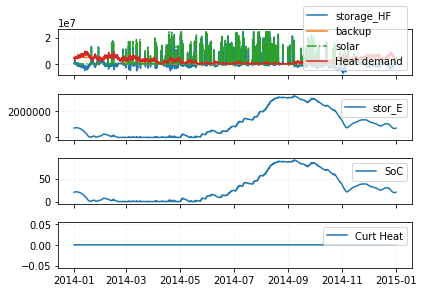

In [21]:
fig, axs = plt.subplots(4,1, sharex=True)

axs[0].plot(optmodel.get_result('heat_flow', node='Node', comp='storage'), label='storage_HF')
axs[0].plot(optmodel.get_result('heat_flow', node='Node', comp='backup'), label='backup')
axs[0].plot(optmodel.get_result('heat_flow', node='Node', comp='solar'),linestyle='-.', label='solar')
axs[0].plot(optmodel.get_result('heat_flow', node='Node', comp='demand'), label='Heat demand')
axs[0].legend()

axs[1].plot(optmodel.get_result('heat_stor', node='Node', comp='storage'), label='stor_E')
axs[1].legend()

axs[2].plot(optmodel.get_result('soc', node='Node', comp='storage'), label='SoC')
axs[2].legend()

axs[3].plot(optmodel.get_result('heat_flow_curt', node='Node', comp='solar'), label='Curt Heat')
axs[3].legend()

for ax in axs:
    ax.grid(alpha=0.3, linestyle=':')

fig.tight_layout()

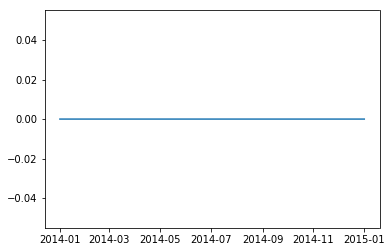

In [22]:
fig, axs = plt.subplots(1,1)

axs.plot(optmodel.get_result('heat_flow_curt', node='Node', comp='solar'), label='Curt Heat')

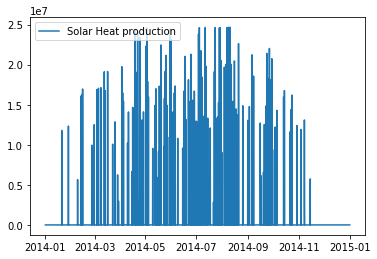

In [23]:
fig, axs = plt.subplots(1,1)

axs.plot(optmodel.get_result('heat_flow', node='Node', comp='solar'), label='Solar Heat production')
axs.legend()

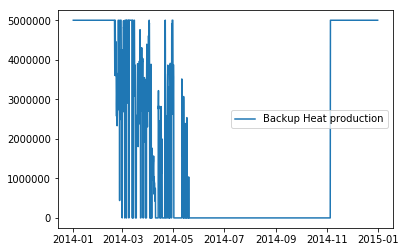

In [24]:
fig, axs = plt.subplots(1,1)

axs.plot(optmodel.get_result('heat_flow', node='Node', comp='backup'), label='Backup Heat production')
axs.legend()

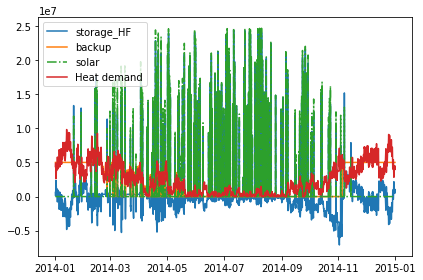

In [25]:
fig, axs = plt.subplots()

axs.plot(optmodel.get_result('heat_flow', node='Node', comp='storage'), label='storage_HF')
axs.plot(optmodel.get_result('heat_flow', node='Node', comp='backup'), label='backup')
axs.plot(optmodel.get_result('heat_flow', node='Node', comp='solar'),linestyle='-.', label='solar')
axs.plot(optmodel.get_result('heat_flow', node='Node', comp='demand'), label='Heat demand')
axs.legend()

fig.tight_layout()